In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score
import umap
import os
import yaml

import import_ipynb
import model_correlation_epoch_evolution
from model_correlation_epoch_evolution import get_models_path, get_epochs, check_embeddings, loader, chose_target, scale_based_on_UKB, classifier

In [35]:
sns.set_theme(style="darkgrid")

In [36]:
# rootdir = '/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-23/' #Strange one, likely due to branch merging issues 

rootdir = '/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Output/2024-05-27/' # very consistent
# rootdir = '/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Output/2024-05-28/' # very consistent too
# rootdir = '/neurospin/dico/adufournet/Runs/04_Heritability_Right_PCS_HCP_dim10/Output/2024-05-29/' # to try !!!! Strange one too

# rootdir = '/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-29/' # to try !!! very consistent
# rootdir = '/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-23/' # what is expected

In [37]:
def encoder(df, columns):
    for col in columns:
        code = {'present':1,
                'absent':0}
        df[col] = df[col].map(code)
    return df

labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Left_PCS', 'Right_PCS']]

encoder(labels_ACCP, ['Left_PCS', 'Right_PCS']) 
labels_ACCP['Asymmetry'] = abs(labels_ACCP.Left_PCS - labels_ACCP.Right_PCS)
labels_ACCP['Two_PCS'] = labels_ACCP.Left_PCS & labels_ACCP.Right_PCS
labels_ACCP['Zero_PCS'] = (1-labels_ACCP.Left_PCS) & (1-labels_ACCP.Right_PCS)
labels_ACCP['Left_without_Right_PCS'] = (labels_ACCP.Left_PCS) & (1-labels_ACCP.Right_PCS)
labels_ACCP['Right_without_Left_PCS'] = (1-labels_ACCP.Left_PCS) & (labels_ACCP.Right_PCS)

In [38]:
list_to_drop = ['Asymmetry','Left_PCS','Right_PCS','Two_PCS','Zero_PCS','Right_without_Left_PCS','Left_without_Right_PCS']

list_model = get_models_path(rootdir)   
epochs = get_epochs(f'{rootdir}{list_model[0]}/')
target = 'Right_PCS'

5it [02:52, 34.46s/it]


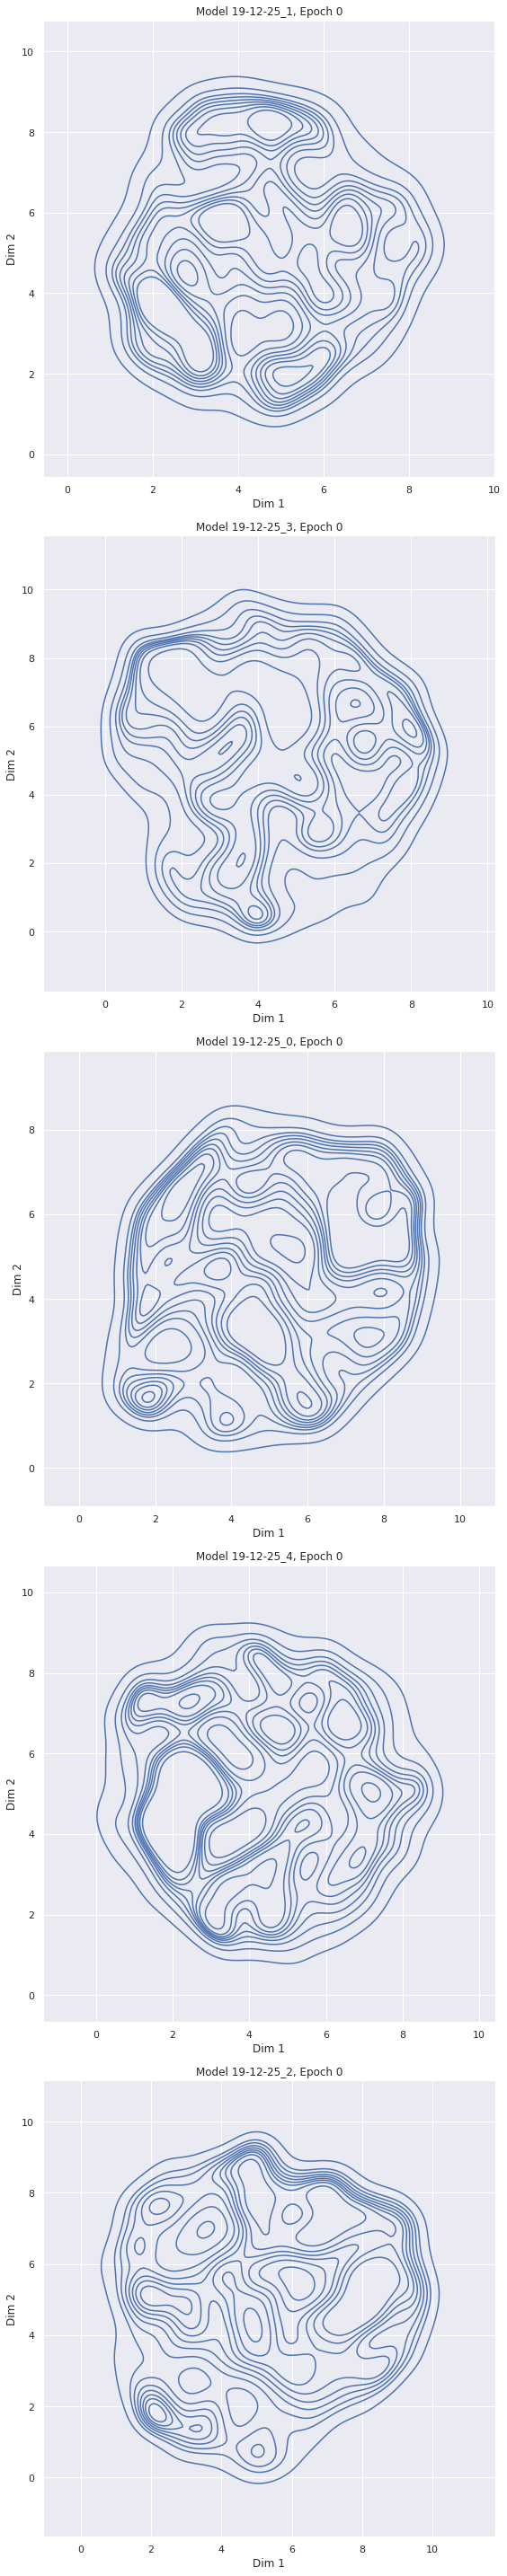

5it [02:31, 30.31s/it]


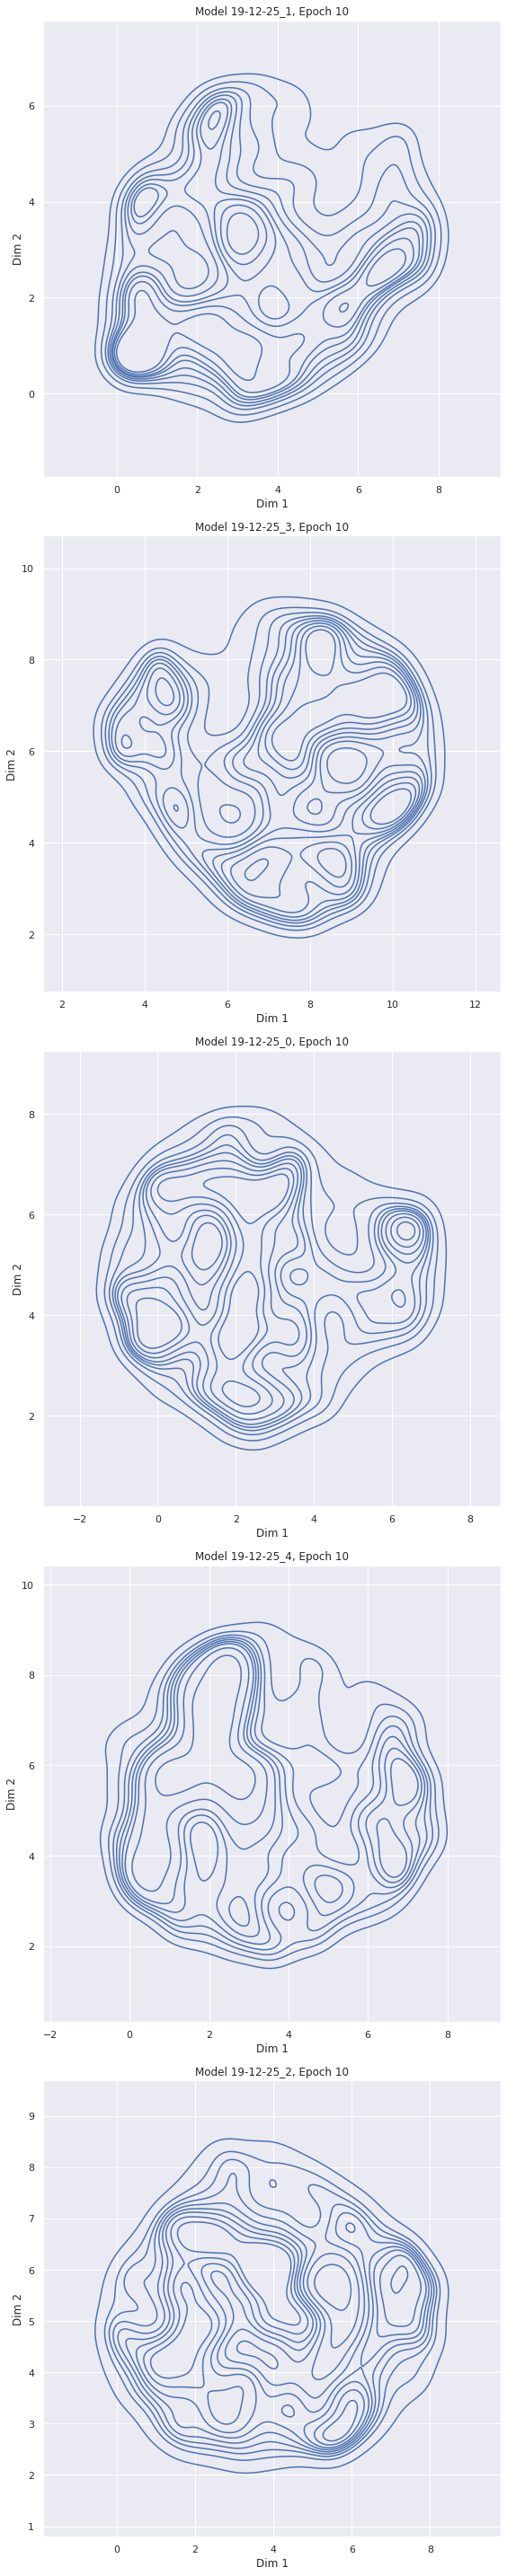

5it [02:32, 30.57s/it]


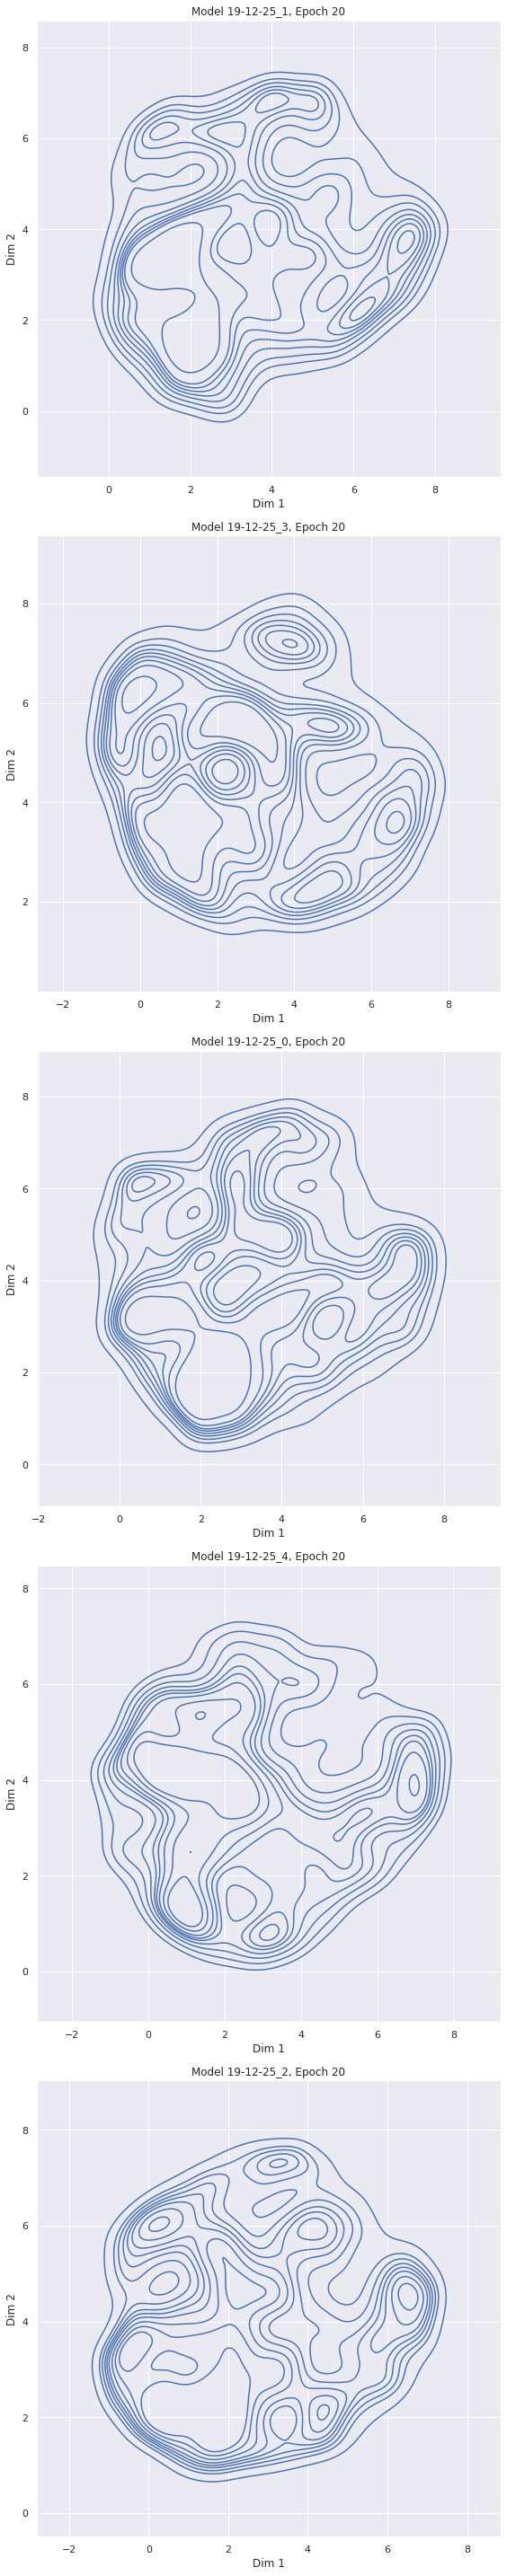

5it [02:29, 29.91s/it]


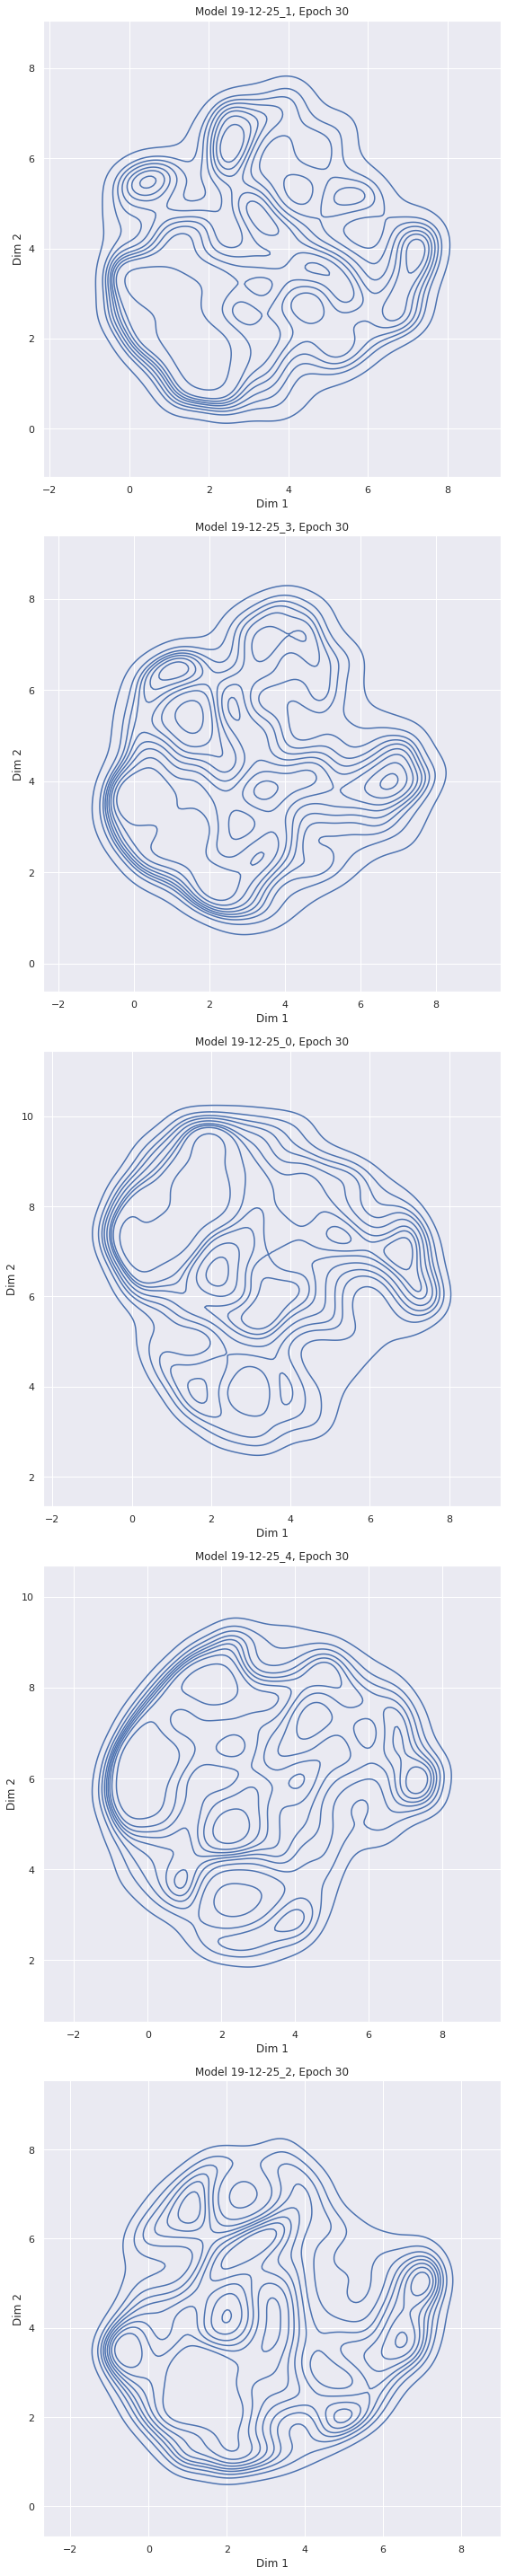

5it [02:29, 29.82s/it]


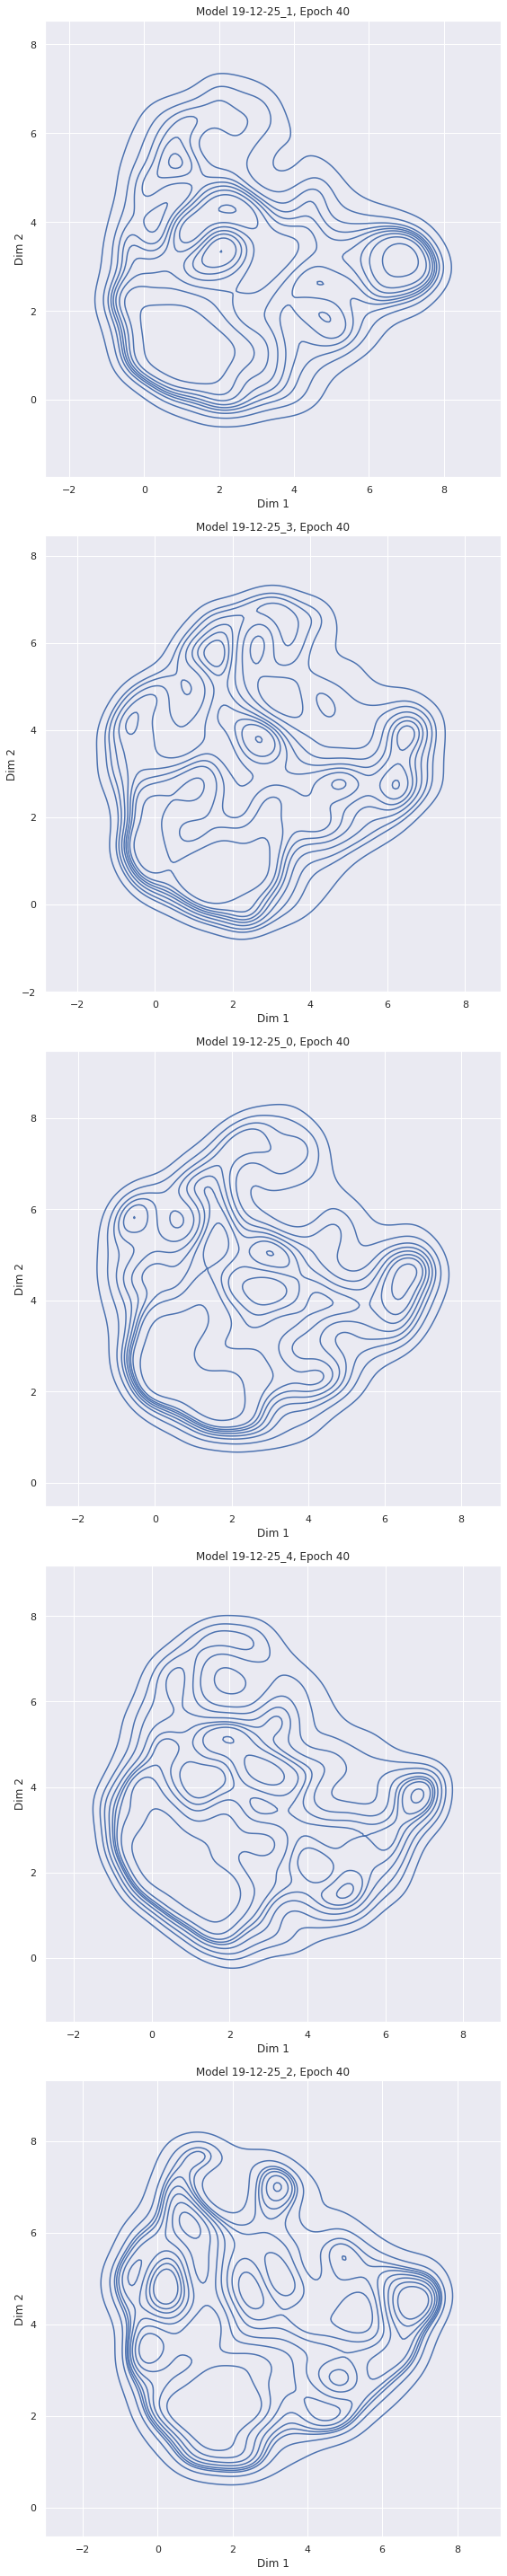

5it [02:38, 31.77s/it]


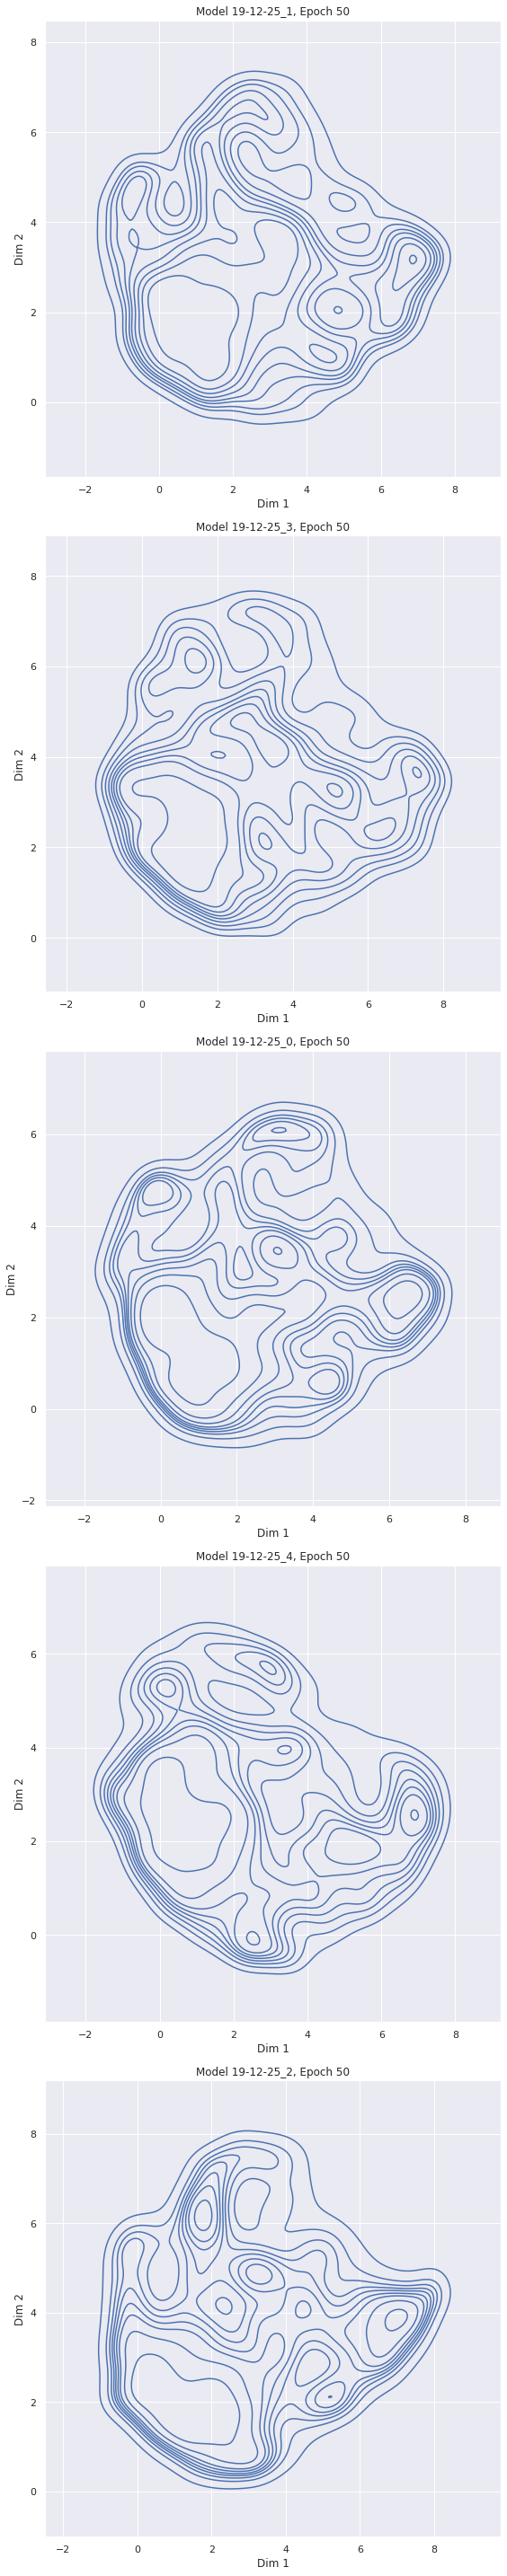

5it [02:36, 31.27s/it]


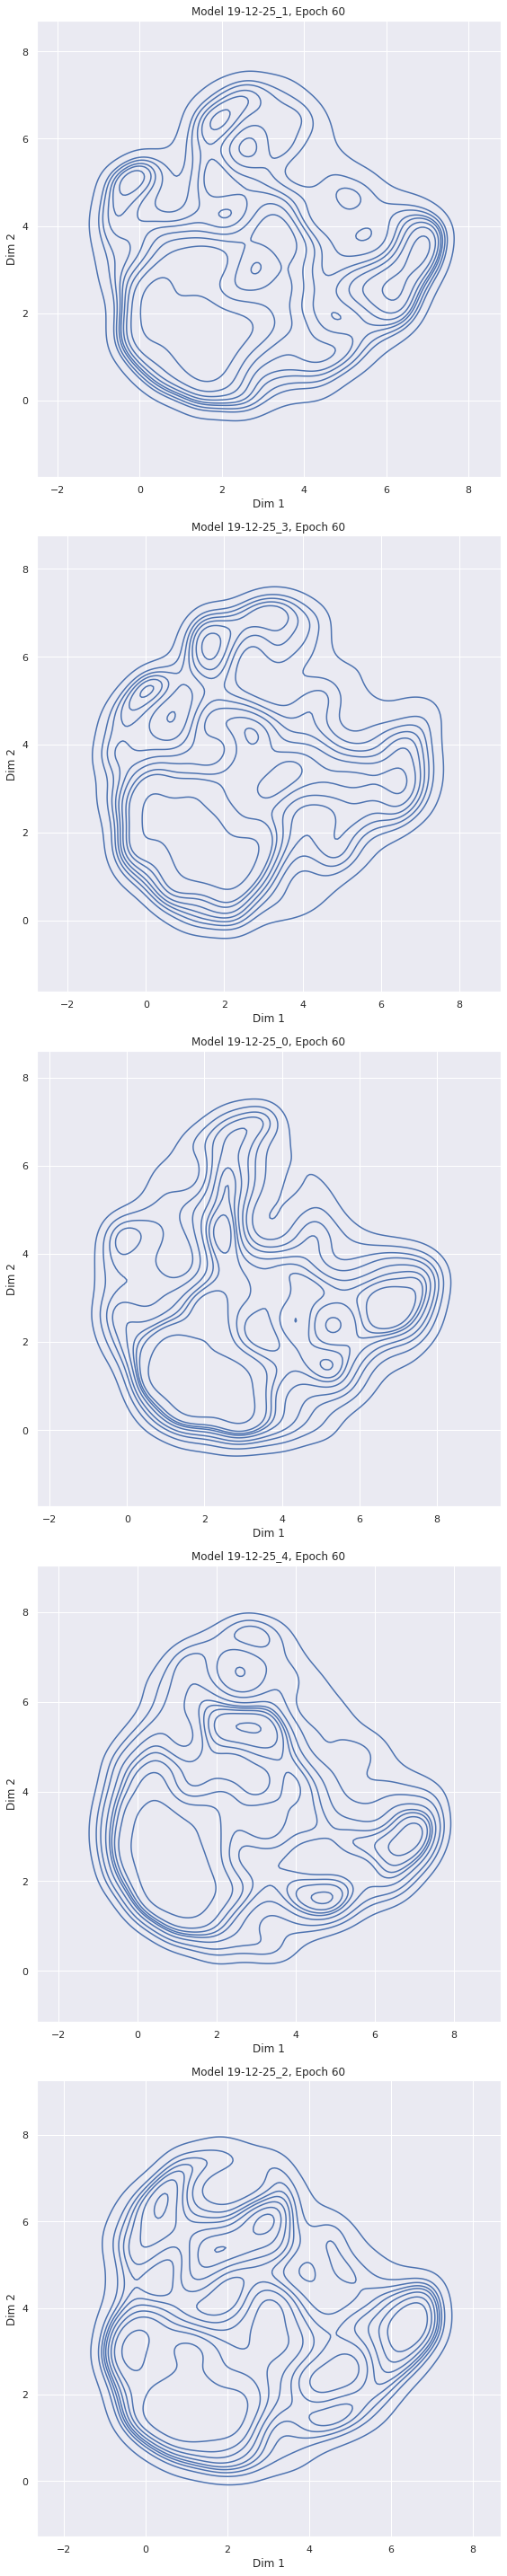

5it [02:40, 32.11s/it]


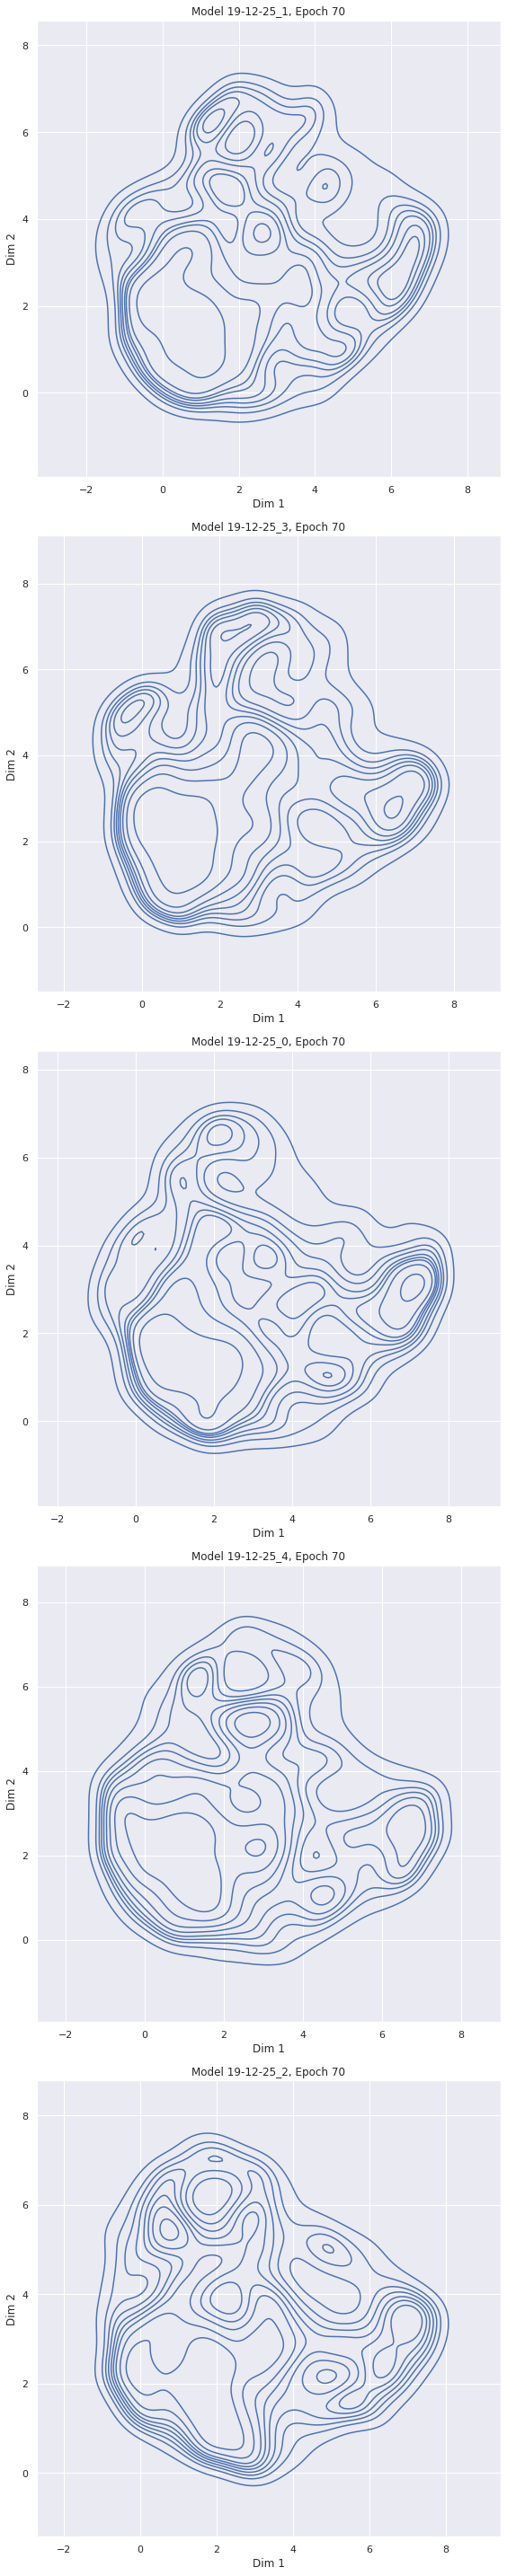

In [41]:
classification_evaluation = False

stratification_evaluation = False

strat_dic = {}
strat_path = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/'

for file in os.listdir(strat_path):
    if file.startswith('ACCpatterns_subjects_train_split'):
        strat_dic[f'train{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")
    if file.startswith('ACCpatterns_subjects_test_split'):
        strat_dic[f'test{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")

list_corr_mean = []
list_corr_std = []

eval_dic = {}
for epoch in np.sort(list(epochs)):
    fig, axs = plt.subplots(len(list_model), figsize=(8, 8 * len(list_model)))
    pred_dic = {}
    for i, str_model in tqdm(enumerate(list_model)):
            path = f'{rootdir}{str_model}/'
            #path = str_model+'/'
            embeddings_ACCP, embeddings_HCP, embeddings_UKB = loader(path, epoch)

            ebdd_lbl_ACCP, X, y = chose_target(target, embeddings_ACCP, labels_ACCP)

            scl_bdd_accp, scl_bdd_hcp, scl_bdd_ukb, scaler = scale_based_on_UKB(X, embeddings_HCP, embeddings_UKB)
            X = scl_bdd_accp
            model = classifier()

            if classification_evaluation:
                if stratification_evaluation:
                    X_train, X_test = np.array([[]]), np.array([[]])
                    y_train, y_test = [], []
                    for key in strat_dic.keys():
                        if key.startswith('train'):
                            new_train_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop(list_to_drop, axis=1).to_numpy()
                            X_train = np.vstack((X_train, new_train_lines)) if X_train.size else new_train_lines
                            y_train += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]][target].to_list()
                        
                        if key.startswith('test'):
                            new_test_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop(list_to_drop, axis=1).to_numpy()
                            X_test = np.vstack((X_test, new_test_lines)) if X_test.size else new_test_lines
                            y_test += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]][target].to_list()

                    X_train = scaler.transform(X_train)
                    X_test = scaler.transform(X_test)
                    model.fit(X_train, y_train)
                    eval_dic[f'auc_{target}_model{str_model[-1]}_epoch{epoch}'] = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
                    eval_dic[f'balanced_accuracy_score_{target}_model{str_model[-1]}_epoch{epoch}'] = balanced_accuracy_score(y_test, model.predict(X_test))
                    X_train, X_test = np.array([[]]), np.array([[]])
                    y_train, y_test = [], []
                else:
                    val_pred = cross_val_predict(model, X, y, cv=5)
                    auc = roc_auc_score(y, val_pred)
                    eval_dic[f'auc_{target}_model{str_model[-1]}_epoch{epoch}'] = roc_auc_score(y, val_pred)
                    eval_dic[f'balanced_accuracy_score_{target}_model{str_model[-1]}_epoch{epoch}'] = balanced_accuracy_score(y, val_pred)
                    
            reducer = umap.UMAP()
            reducer.fit(scl_bdd_ukb)
            
            bdd_2D_HCP = reducer.transform(scl_bdd_hcp)
            bdd_2D_UKB = reducer.transform(scl_bdd_ukb) 
            bdd_2D_ACCP = reducer.transform(scl_bdd_accp) 

            bdd_2D_HCP = pd.DataFrame(bdd_2D_HCP, columns=['Dim 1', 'Dim 2'])
            bdd_2D_UKB = pd.DataFrame(bdd_2D_UKB, columns=['Dim 1', 'Dim 2'])
            bdd_2D_ACCP = pd.DataFrame(bdd_2D_ACCP, columns=['Dim 1', 'Dim 2'])

            bdd_2D_HCP['Dataset'] = 'hcp'
            bdd_2D_UKB['Dataset'] = 'UkBioBank'
            bdd_2D_ACCP['Dataset'] = 'accp'
            
            sns.kdeplot(
                data=bdd_2D_UKB,
                x="Dim 1",
                y="Dim 2",
                thresh=.1,
                ax=axs[i]
            )
            axs[i].set_title(f'Model {str_model}, Epoch {epoch}')

    plt.tight_layout()
    plt.show()


In [32]:
eval_dic

{'auc_Right_PCS_model1_epoch0': 0.4829493087557603,
 'balanced_accuracy_score_Right_PCS_model1_epoch0': 0.4382488479262673,
 'auc_Right_PCS_model3_epoch0': 0.487557603686636,
 'balanced_accuracy_score_Right_PCS_model3_epoch0': 0.49539170506912444,
 'auc_Right_PCS_model0_epoch0': 0.5428571428571428,
 'balanced_accuracy_score_Right_PCS_model0_epoch0': 0.5778801843317972,
 'auc_Right_PCS_model4_epoch0': 0.7184331797235022,
 'balanced_accuracy_score_Right_PCS_model4_epoch0': 0.6456221198156682,
 'auc_Right_PCS_model2_epoch0': 0.5502304147465438,
 'balanced_accuracy_score_Right_PCS_model2_epoch0': 0.5474654377880184,
 'auc_Right_PCS_model1_epoch10': 0.8138248847926268,
 'balanced_accuracy_score_Right_PCS_model1_epoch10': 0.7101382488479262,
 'auc_Right_PCS_model3_epoch10': 0.7741935483870966,
 'balanced_accuracy_score_Right_PCS_model3_epoch10': 0.7511520737327189,
 'auc_Right_PCS_model0_epoch10': 0.8211981566820277,
 'balanced_accuracy_score_Right_PCS_model0_epoch10': 0.7244239631336405,
 '